In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import importlib
import torch
import pandas as pd
import os
import sys
import json
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from recover.utils.utils import get_tensor_dataset
import reservoir as rdl
from copy import deepcopy
import numpy as np
from tqdm import tqdm
from recover.datasets.drugcomb_matrix_data import DrugCombMatrixTrainAlmanac
import matplotlib.pyplot as plt
import seaborn as sns

# sns.set_theme()
sns.set_style("ticks")

In [2]:
def get_all_results(logdir_list):
    
    All_results = None

    for logdir in logdir_list:
        for directory in os.listdir(logdir):
            if directory.startswith("Active"):
                f = open(os.path.join(logdir, directory, "params.json"))
                params = json.load(f)
                f.close()

                progress = pd.read_csv(os.path.join(logdir, directory, "progress.csv"))

                result = pd.DataFrame(progress['top'])
                result['query_true_syn_mean'] = progress['query_true_syn_mean']
                result['n_unique_drugs_in_query'] = progress['n_unique_drugs_in_query']
                result['query_true_syn_quantile_0.5'] = progress['query_true_syn_quantile_0.5']
                result['query_true_syn_quantile_0.0'] = progress['query_true_syn_quantile_0.0']
                result['query_true_syn_quantile_1.0'] = progress['query_true_syn_quantile_1.0']
                result["seen_idxs"] = progress["seen_idxs"]
                result["seen_idxs_in_dataset"] = progress["seen_idxs_in_dataset"]

                result["n_epoch_between_queries"] = params["n_epoch_between_queries"]
                result["acquire_n_at_a_time"] = params["acquire_n_at_a_time"]
                result["n_initial"] = params["n_initial"]
                result["patience_max"] = params["patience_max"]
                result['load_model_weights'] = params['load_model_weights']
                result['acquisition'] = params['acquisition'].split('.')[-1][:-2]
                result['n_initial'] = params['n_initial']
                result['seed'] = params['seed']
                result['kappa'] = params['kappa']
                result['iterations'] = range(len(result))
                result['val_set_prop'] = params['val_set_prop']
                result['target'] = params['target']
                result["cell_line"] = params["cell_line"]

                if All_results is None:
                    All_results = result
                else:
                    All_results = pd.concat((All_results, result))
                    
    All_results = All_results.reset_index()
    All_results["seen_idxs_in_dataset"] = \
    All_results["seen_idxs_in_dataset"].apply(lambda l: [int(idx) for idx in l[1:-1].split(", ")])
                    
    return All_results

## Highlight SMO Recover Single Cell Line

In [3]:
cell_line = "OVCAR3"  # 'HT29', 'OVCAR3', 'SW-620'
total_budget = 120

In [4]:
queried_synergies_recover = []

In [5]:
All_results = pd.concat((get_all_results(["/Users/paul/PycharmProjects/NewReservoir/Recover/RayLogs/"
                               "highlight_smo_recover_single_cell_line"]),
                         get_all_results(["/Users/paul/PycharmProjects/NewReservoir/Recover/RayLogs/"
                               "highlight_smo_recover_single_cell_line_others"])))

In [6]:
All_results = All_results[All_results["cell_line"] == cell_line]

In [7]:
dataset = DrugCombMatrixTrainAlmanac(fp_bits=1024, fp_radius=2, cell_line=cell_line, 
                                     study_name="ALMANAC", in_house_data="without", rounds_to_include=[])



Dataset loaded.
1160 drug comb experiments among 148 drugs
	 fingeprints with radius 2 and nbits 1024
	 drug features dimension 1172
	 1 cell-lines
keep only fingerprint features


In [8]:
for idx in All_results.index:
    seen_indices = All_results["seen_idxs_in_dataset"].loc[idx]
    
    if len(seen_indices) == total_budget:
        queried_synergies_recover.extend(dataset.data.ddi_edge_bliss_max[seen_indices].tolist())

In [9]:
print(len(queried_synergies_recover))

360


## Highlight SMO Recover no adapt

In [10]:
queried_synergies_recover_no_adapt = []

In [11]:
All_results = get_all_results(["/Users/paul/PycharmProjects/NewReservoir/Recover/RayLogs/highlight_smo_"
                               "recover_no_adapt_single_cell_line"])

In [12]:
All_results = All_results[All_results["cell_line"] == cell_line]

In [13]:
for idx in All_results.index:
    seen_indices = All_results["seen_idxs_in_dataset"].loc[idx]

    if len(seen_indices) == 300:
        first_seen_indices = seen_indices[:total_budget]
        queried_synergies_recover_no_adapt.extend(dataset.data.ddi_edge_bliss_max[first_seen_indices].tolist())

## Highlight SMO Deep Synergy

In [14]:
queried_synergies_deep_syn = []

In [15]:
All_results = get_all_results(["/Users/paul/PycharmProjects/NewReservoir/Recover/RayLogs/"
                               "highlight_smo_deep_syn_single_cell_line"])

In [16]:
All_results = All_results[All_results["cell_line"] == cell_line]

In [17]:
for idx in All_results.index:
    seen_indices = All_results["seen_idxs_in_dataset"].loc[idx]
    
    if len(seen_indices) == total_budget:
        queried_synergies_deep_syn.extend(dataset.data.ddi_edge_bliss_max[seen_indices].tolist())

## Highlight SMO Deep Synergy no adapt

In [18]:
queried_synergies_deep_syn_no_adapt = []

In [19]:
All_results = get_all_results(["/Users/paul/PycharmProjects/NewReservoir/Recover/RayLogs/"
                               "highlight_smo_deep_syn_no_adapt_single_cell_line"])

In [20]:
All_results = All_results[All_results["cell_line"] == cell_line]

In [21]:
for idx in All_results.index:
    seen_indices = All_results["seen_idxs_in_dataset"].loc[idx]
    
    if len(seen_indices) == 300:
        
        first_seen_indices = seen_indices[:total_budget]
        queried_synergies_deep_syn_no_adapt.extend(dataset.data.ddi_edge_bliss_max[first_seen_indices].tolist())

## Random

In [22]:
from recover.datasets.drugcomb_matrix_data import DrugCombMatrixTrainAlmanac

queried_synergies_random = []

In [23]:
dataset = DrugCombMatrixTrainAlmanac(
    study_name= 'ALMANAC',
    cell_line= cell_line,
    fp_bits= 1024,
    fp_radius= 2
)

Dataset loaded.
1160 drug comb experiments among 148 drugs
	 fingeprints with radius 2 and nbits 1024
	 drug features dimension 1172
	 1 cell-lines
keep only fingerprint features


In [24]:
# Set seed
for seed in [1, 2, 3]:
    torch.manual_seed(seed)
    np.random.seed(seed)

    config = {"val_set_prop": 0.1, 
              "test_set_prop": 0., 
              "split_valid_train": "pair_level",
              "test_on_unseen_cell_line": False, 
              "cell_line": cell_line,
              "target": "bliss_max"}

    train_idxs, _, _ = dataset.random_split(config)
    
    randomly_queried_idxs = train_idxs[torch.randperm(len(train_idxs))][:total_budget]
    
    queried_synergies_random.extend(dataset.data.ddi_edge_bliss_max[randomly_queried_idxs].tolist())

## Analysis

In [25]:
len(queried_synergies_deep_syn)

360

In [26]:
len(queried_synergies_recover)

360

In [27]:
len(queried_synergies_deep_syn_no_adapt)

360

In [28]:
len(queried_synergies_recover_no_adapt)

360

In [29]:
len(queried_synergies_random)

360

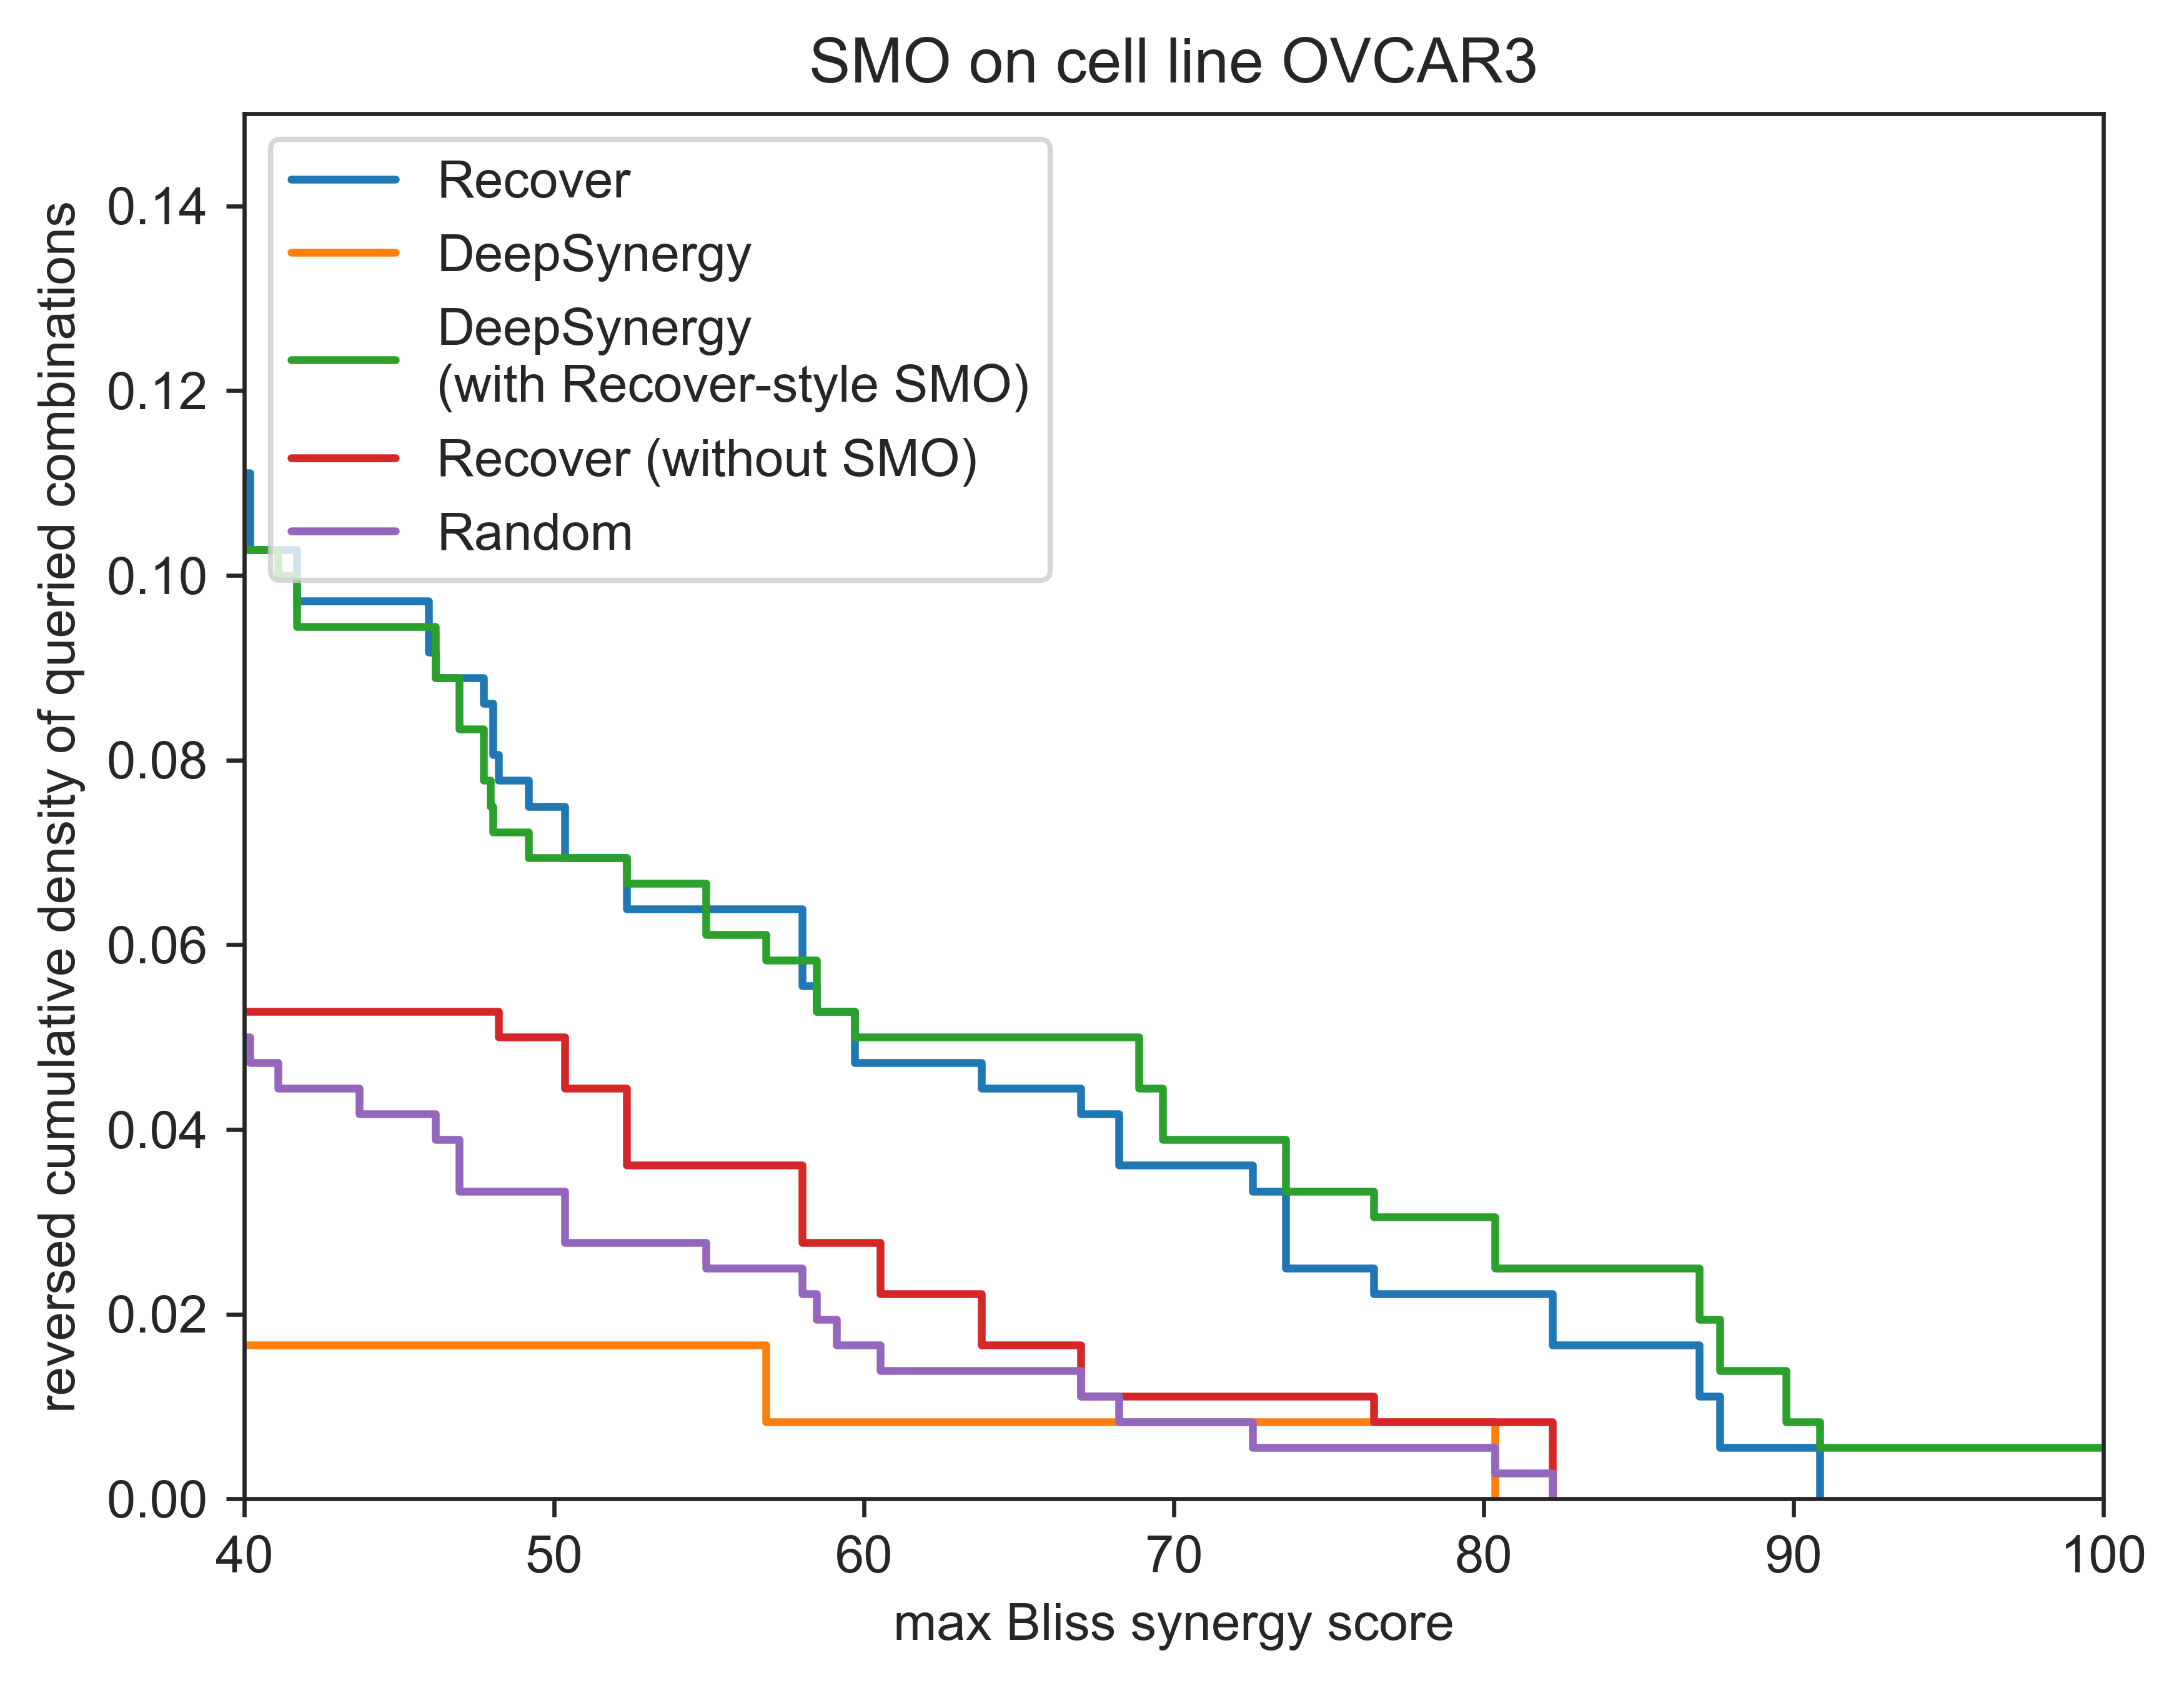

In [32]:
# plt.figure(figsize=(8, 6), dpi=600)
plt.figure(dpi=600)
sns.ecdfplot(queried_synergies_recover, complementary=True, label="Recover")
sns.ecdfplot(queried_synergies_deep_syn_no_adapt, complementary=True, label="DeepSynergy")
sns.ecdfplot(queried_synergies_deep_syn, complementary=True, label="DeepSynergy\n(with Recover-style SMO)")
sns.ecdfplot(queried_synergies_recover_no_adapt, complementary=True, label="Recover (without SMO)")
sns.ecdfplot(queried_synergies_random, complementary=True, label="Random")
plt.legend(loc='upper left') # ,  bbox_to_anchor=(0.1, 1.))

plt.title("SMO on cell line " + cell_line)
plt.xlabel("max Bliss synergy score")
plt.ylabel("reversed cumulative density of queried combinations")
# plt.title("Reversed cumulative density of the synergies of all queried combinations")
plt.xlim(40, 100)
# plt.ylim(0, 0.125)
plt.ylim(0, 0.15)
plt.show()

In [33]:
upper_lim = 80

In [34]:
list_length = len(queried_synergies_recover)

x_min = 0
x_max = upper_lim

reversed_cum_dist_deep_syn = [sum([s > x for s in queried_synergies_deep_syn])/list_length
                     for x in range(x_min, x_max)]
reversed_cum_dist_recover = [sum([s > x for s in queried_synergies_recover])/list_length
                     for x in range(x_min, x_max)]
reversed_cum_dist_deep_syn_no_adapt = [sum([s > x for s in queried_synergies_deep_syn_no_adapt])/list_length 
                     for x in range(x_min, x_max)]
reversed_cum_dist_recover_no_adapt = [sum([s > x for s in queried_synergies_recover_no_adapt])/list_length 
                     for x in range(x_min, x_max)]
reversed_cum_dist_random = [sum([s > x for s in queried_synergies_random])/list_length
                     for x in range(x_min, x_max)]

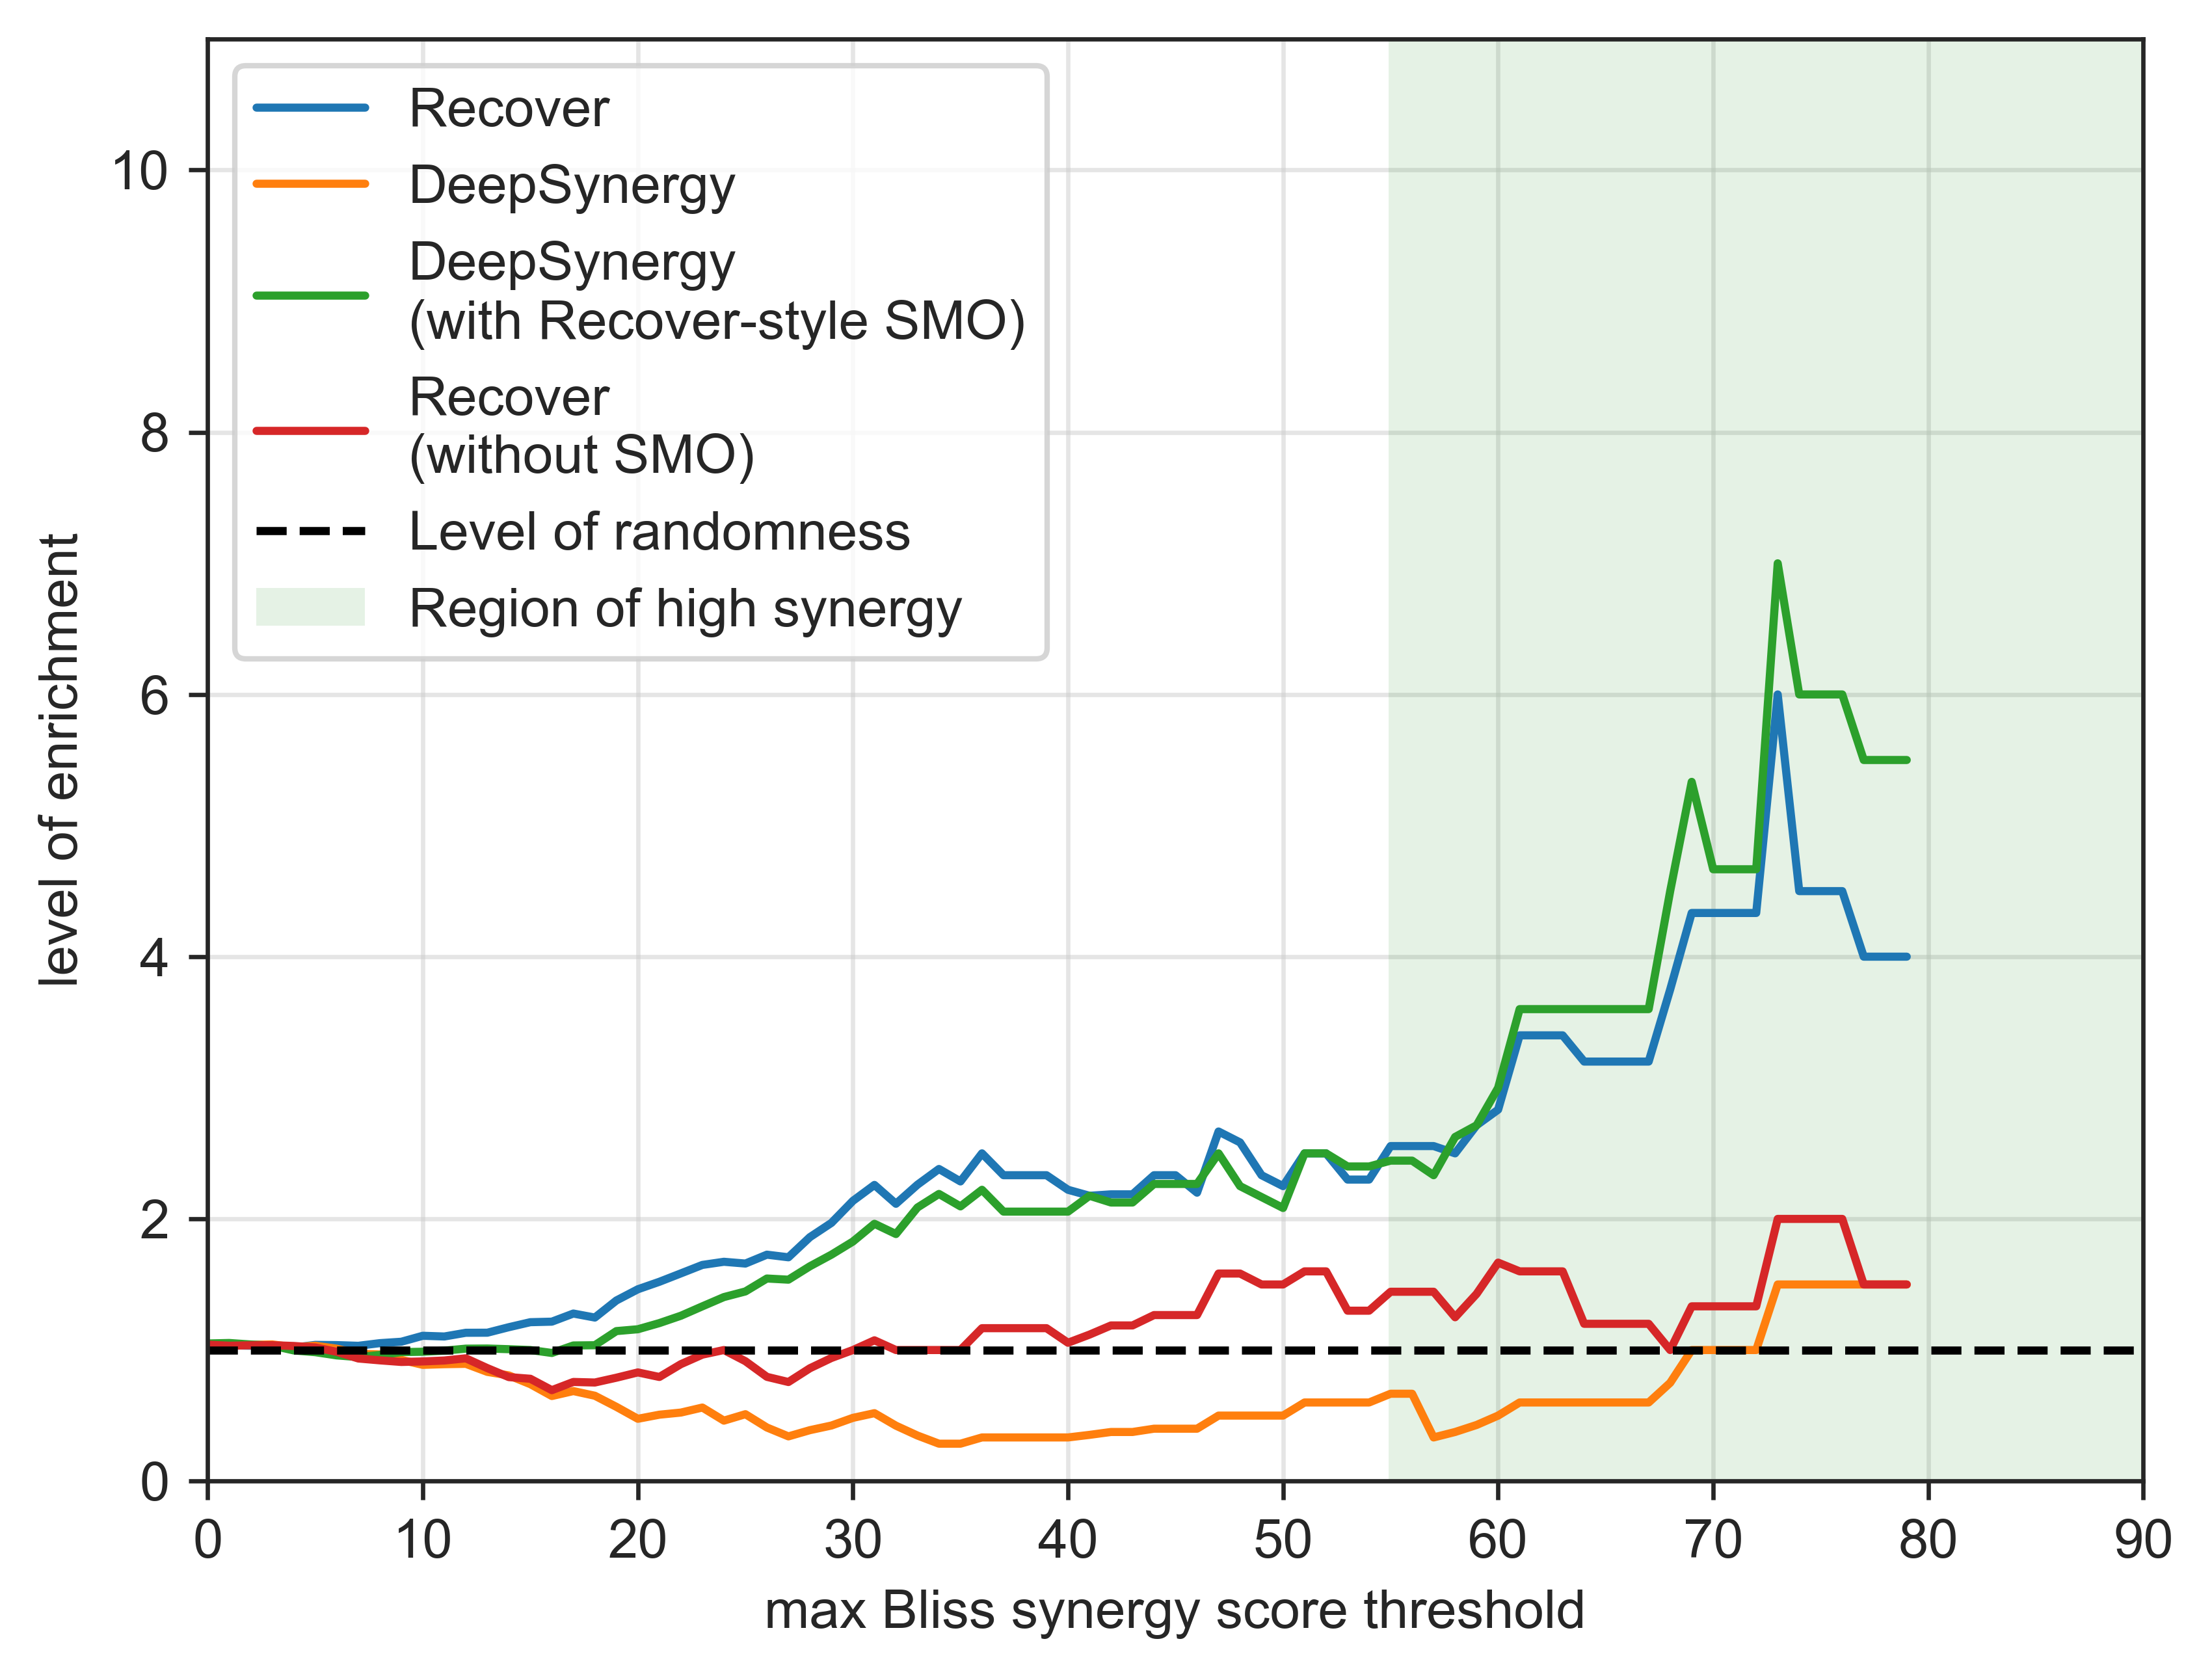

In [35]:
enrichment_deep_syn = [a/(b) for a, b in zip(reversed_cum_dist_deep_syn, reversed_cum_dist_random)]
enrichment_recover = [a/(b) for a, b in zip(reversed_cum_dist_recover, reversed_cum_dist_random)]
enrichment_deep_syn_no_adapt = [a/(b) for a, b in zip(reversed_cum_dist_deep_syn_no_adapt, 
                                                             reversed_cum_dist_random)]
enrichment_recover_no_adapt = [a/(b) for a, b in zip(reversed_cum_dist_recover_no_adapt, 
                                                            reversed_cum_dist_random)]


plt.figure(dpi=600)
plt.plot(range(x_min, x_max), enrichment_recover, label="Recover")
plt.plot(range(x_min, x_max), enrichment_deep_syn_no_adapt, label="DeepSynergy")
plt.plot(range(x_min, x_max), enrichment_deep_syn, label="DeepSynergy\n(with Recover-style SMO)")
plt.plot(range(x_min, x_max), enrichment_recover_no_adapt, label="Recover\n(without SMO)")

plt.axhline(y=1, color='k', linestyle='--', label="Level of randomness")
plt.axvspan(xmin=54.9, xmax=90, color='green', alpha=0.1, lw=0, label="Region of high synergy")

plt.grid(visible=True, which="major", alpha=0.5)
plt.grid(visible=True, which="minor", alpha=0.2)
plt.ylim(0, 11)
plt.xlim(0, 90)
plt.legend(loc='upper left')

plt.xlabel("max Bliss synergy score threshold")
plt.ylabel("level of enrichment")

plt.show()

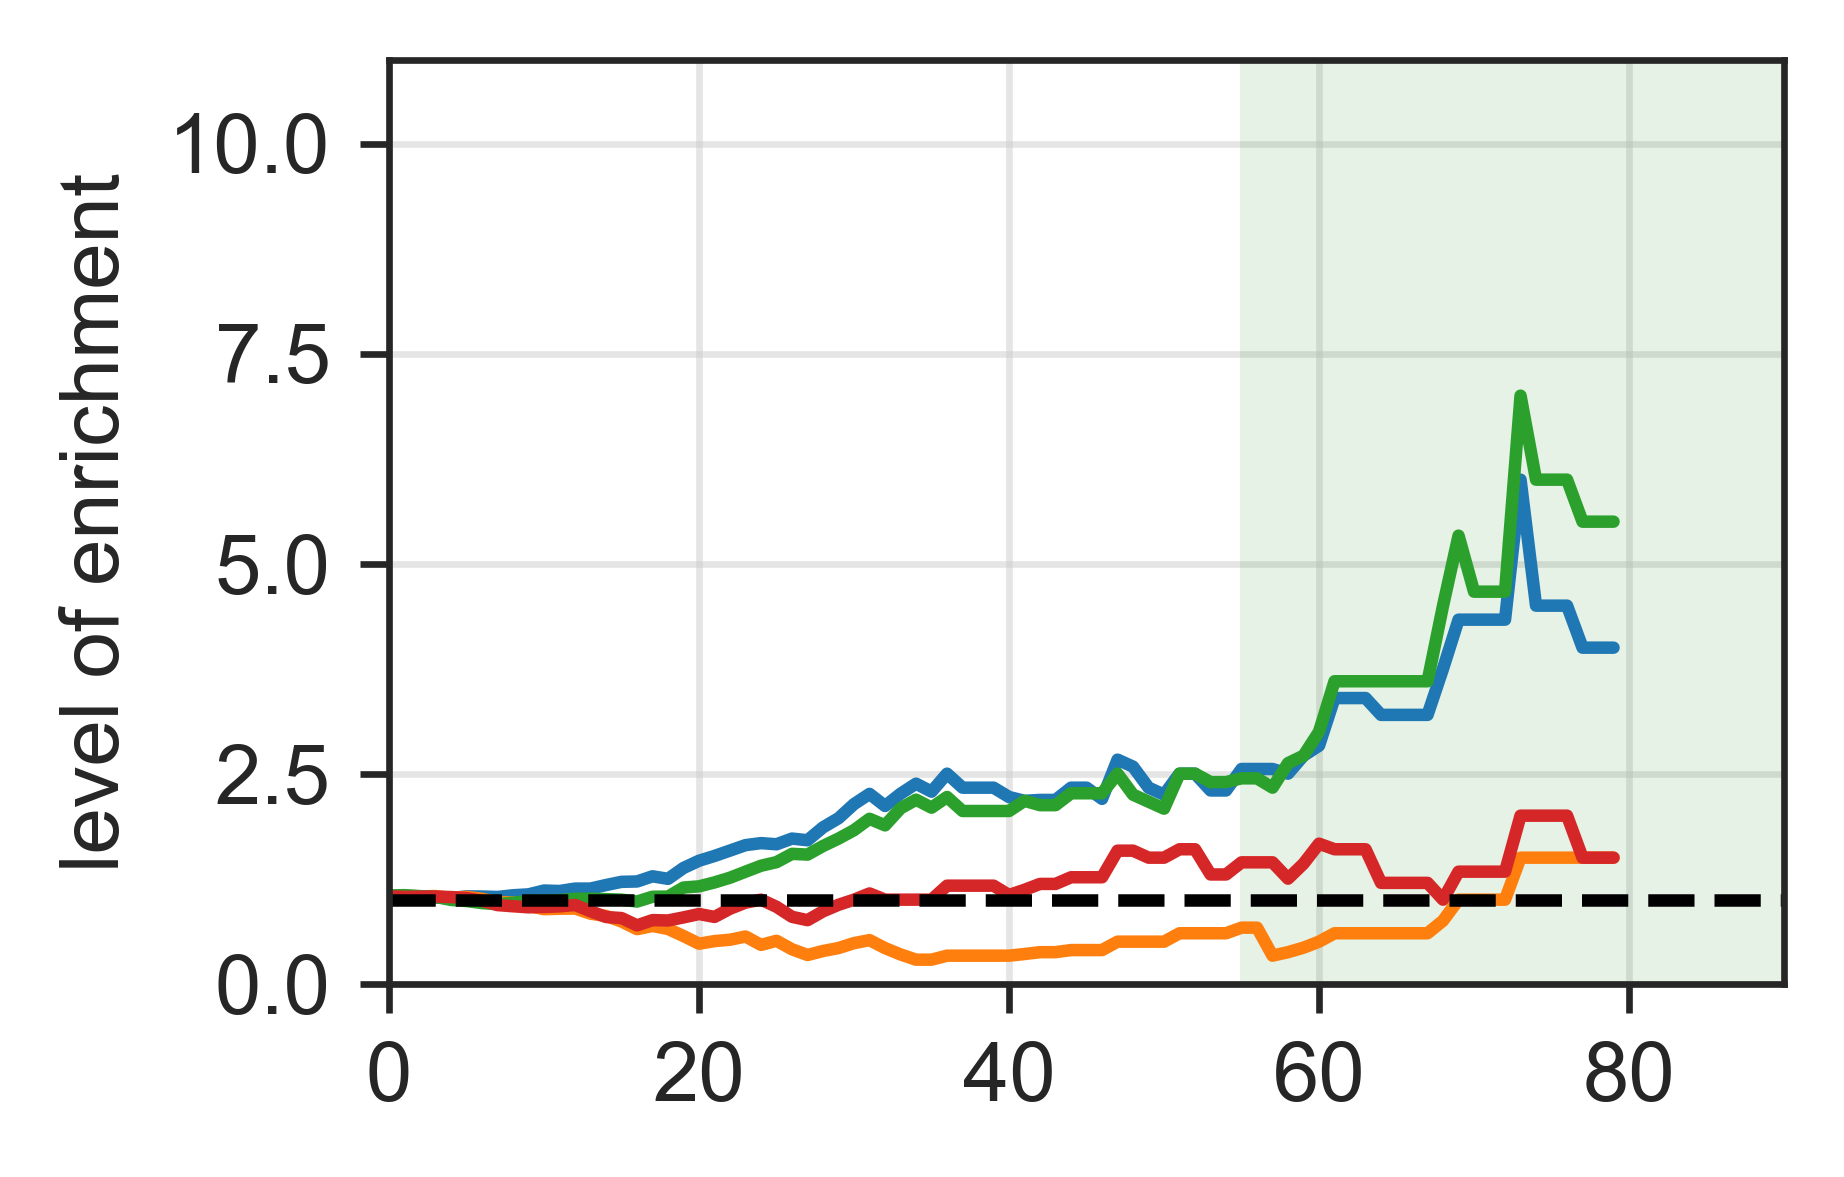

In [36]:
plt.figure(figsize=(3, 2), dpi=600)
plt.plot(range(x_min, x_max), enrichment_recover)
plt.plot(range(x_min, x_max), enrichment_deep_syn_no_adapt)
plt.plot(range(x_min, x_max), enrichment_deep_syn)
plt.plot(range(x_min, x_max), enrichment_recover_no_adapt)

plt.axhline(y=1, color='k', linestyle='--', label="Level of\nrandomness")
plt.axvspan(xmin=54.9, xmax=90, color='green', alpha=0.1, lw=0, label="Region of\nhigh synergy")

plt.grid(visible=True, which="major", alpha=0.5)
plt.grid(visible=True, which="minor", alpha=0.2)
plt.ylim(0, 11)
plt.xlim(0, 90)
plt.ylabel("level of enrichment")

plt.show()